### Import libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### Read in hotfilm
Reading in one single dataset for now as proof of concept. Future work will read in all hotfilm data, likely using glob. 

In [2]:
# Read in single dataset
hotfilm = xr.open_dataset('/scr/isfs/projects/M2HATS/netcdf/hotfilm.20241219/hotfilm_volts_20230905_000000_120.nc')

In [3]:
# Average every 5 mins
hotfilm_5min_avg = hotfilm.resample(time='5min').mean()

# Offset by 2 mins 30 seconds for ISFS standard
hotfilm_5min_avg['time'] = hotfilm_5min_avg['time'] + np.timedelta64(2, 'm') + np.timedelta64(30, 's')

# Remove last time point as it is not a full 5 mins
hotfilm_5min_avg = hotfilm_5min_avg.isel(time=slice(0, -1))

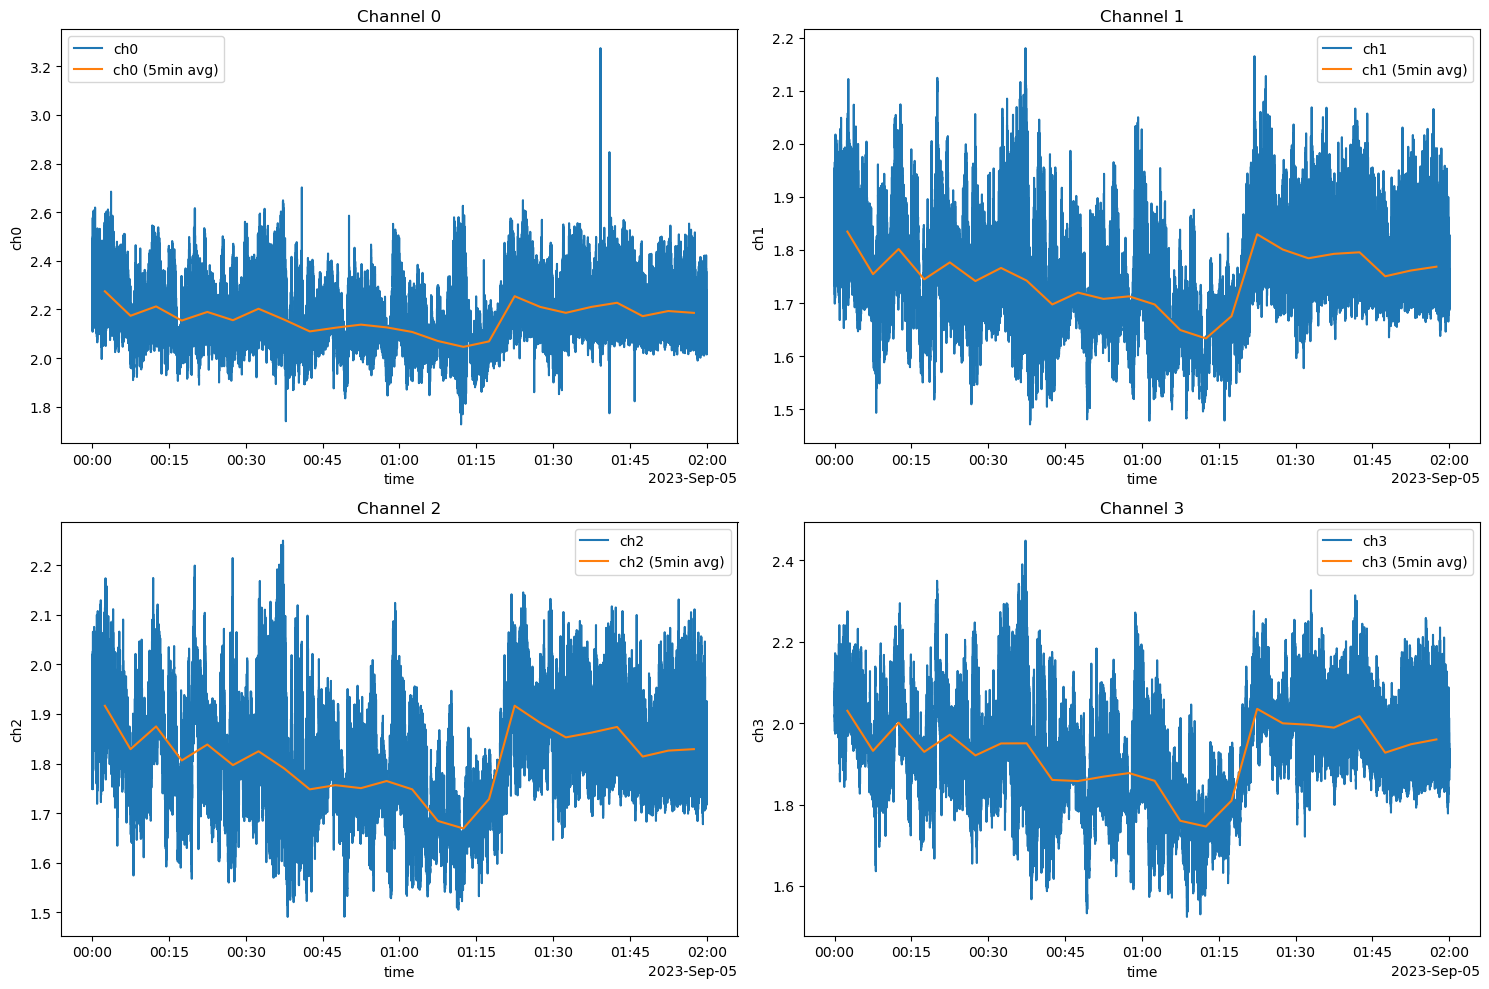

In [4]:
# Visualize hotfilm data, instantaneous and 5min average
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot ch0
hotfilm['ch0'].plot.line(ax=axs[0, 0], label='ch0')
hotfilm_5min_avg['ch0'].plot.line(ax=axs[0, 0], label='ch0 (5min avg)')
axs[0, 0].set_title('Channel 0')
axs[0, 0].legend()

# Plot ch1
hotfilm['ch1'].plot.line(ax=axs[0, 1], label='ch1')
hotfilm_5min_avg['ch1'].plot.line(ax=axs[0, 1], label='ch1 (5min avg)')
axs[0, 1].set_title('Channel 1')
axs[0, 1].legend()

# Plot ch2
hotfilm['ch2'].plot.line(ax=axs[1, 0], label='ch2')
hotfilm_5min_avg['ch2'].plot.line(ax=axs[1, 0], label='ch2 (5min avg)')
axs[1, 0].set_title('Channel 2')
axs[1, 0].legend()

# Plot ch3
hotfilm['ch3'].plot.line(ax=axs[1, 1], label='ch3')
hotfilm_5min_avg['ch3'].plot.line(ax=axs[1, 1], label='ch3 (5min avg)')
axs[1, 1].set_title('Channel 3')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### Read in sonics

In [5]:
# Read in a single 5-min averaged dataset (covers 24 hours)
sonic_dataset = xr.open_dataset('/export/flash/isf/isfs/data/M2HATS/netcdf/qc_geo_tiltcor.20240816/isfs_m2hats_qc_geo_tiltcor_5min_20230905_000000.nc')

### Compare
Creating calibration curves and plotting voltage vs. wind speed. This section is still a work in progress, and I have to:
1. Rotate the wind vector.
2. Further understand and implement the calibration equation using Steve's code and https://www.thermopedia.com/content/853/
3. Further check the equation to ensure it's pulling in the data it needs to. 

**It's important to note that these calibration curves are NOT correct. Just the beginning of the concept.**

In [6]:
# Align the datasets by time (align sonic time to hotfilm)
aligned_sonic_dataset = sonic_dataset.sel(time=hotfilm_5min_avg.time)

In [7]:
# Define the calibration function taken from Steve's plots.
#! Don't take this for truth, I need to read the math behind the equation -- just a placeholder for now #!
def calibration_function(x, a, b):
    return ((x**2 - a) / b)**(1/0.45)

# Define a function to plot hotfilm vs sonic data and a calibration curve
def plot_scatter_and_curve(ax, sonic_data, hotfilm_data, title, xlabel, ylabel):
    ax.scatter(sonic_data, hotfilm_data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Perform the curve fitting
    popt, _ = curve_fit(calibration_function, hotfilm_data, sonic_data)
    a_opt, b_opt = popt

    # Plot the calibration curve
    x_fit = np.linspace(hotfilm_data.min(), hotfilm_data.max(), 100)
    y_fit = calibration_function(x_fit, *popt)
    ax.plot(y_fit, x_fit, color='red', label=f'Fit: x = ((y^2 - {a_opt:.2f})/{b_opt:.2f})^(1/0.45)')
    ax.legend()

    return a_opt, b_opt

In [8]:
# Create a dataset to store the calibration parameters
calibration_data = xr.Dataset(
    {
        'a_value': (['hour', 'level'], np.zeros((len(np.arange(hotfilm_5min_avg.time.dt.hour[0], hotfilm_5min_avg.time.dt.hour[-1] + 1)), 4))),
        'b_value': (['hour', 'level'], np.zeros((len(np.arange(hotfilm_5min_avg.time.dt.hour[0], hotfilm_5min_avg.time.dt.hour[-1] + 1)), 4)))
    },
    coords={
        'hour': np.arange(hotfilm_5min_avg.time.dt.hour[0], hotfilm_5min_avg.time.dt.hour[-1] + 1),
        'level': ['.5m', '1m', '2m', '4m']
    }
)

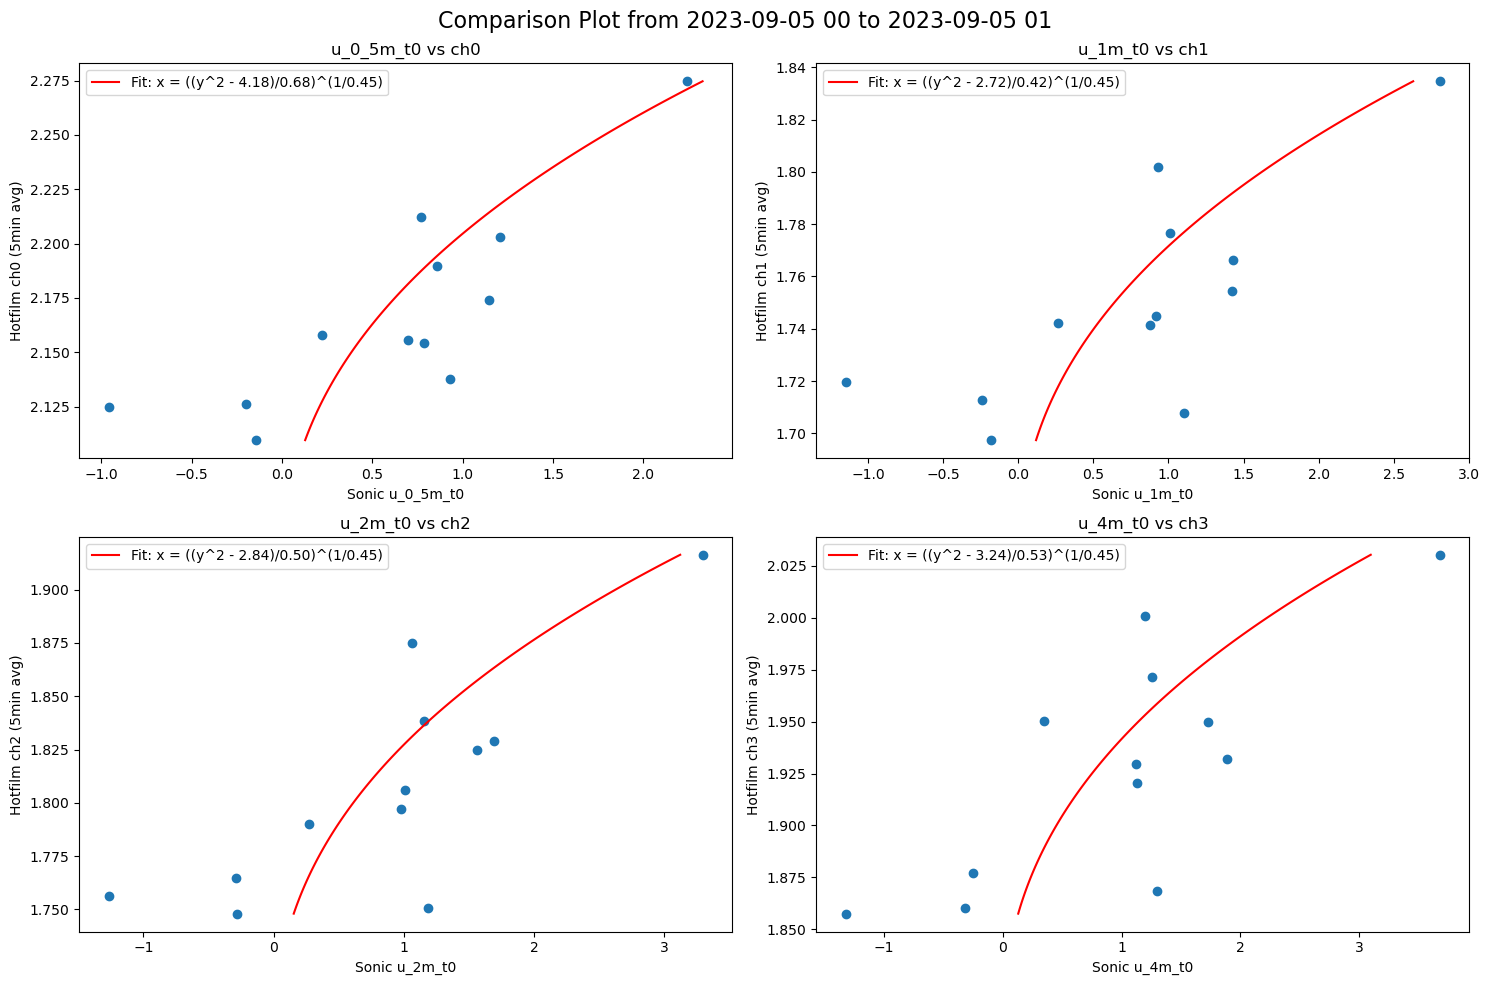

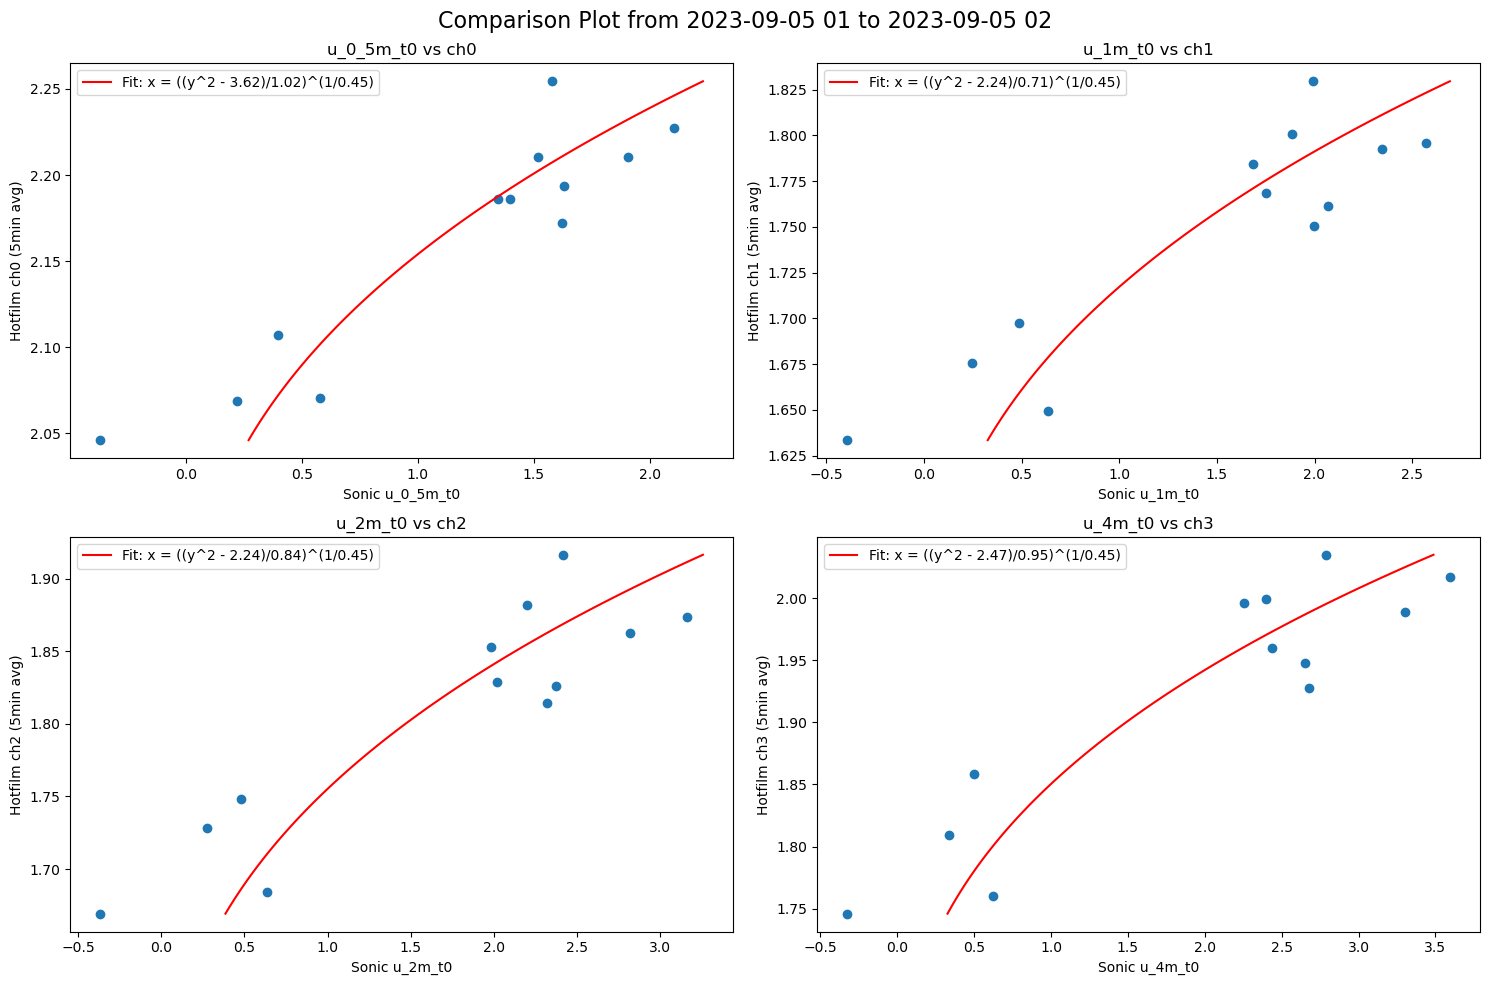

In [9]:
# Iterate for every hour in the hotfilm dataset
for hour in np.arange(hotfilm_5min_avg.time.dt.hour[0], hotfilm_5min_avg.time.dt.hour[-1] + 1):
    hourly_sonic = aligned_sonic_dataset.sel(time=aligned_sonic_dataset.time.dt.hour == hour)
    hourly_hotfilm = hotfilm_5min_avg.sel(time=hotfilm_5min_avg.time.dt.hour == hour)

    # Make four-panel comparison plot 
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Scatter plot for u_0_5m_t0 vs ch0
    a0, b0 = plot_scatter_and_curve(axs[0, 0], hourly_sonic['u_0_5m_t0'], hourly_hotfilm['ch0'],
                                    'u_0_5m_t0 vs ch0', 'Sonic u_0_5m_t0', 'Hotfilm ch0 (5min avg)')

    # Scatter plot for u_1m_t0 vs ch1
    a1, b1 = plot_scatter_and_curve(axs[0, 1], hourly_sonic['u_1m_t0'], hourly_hotfilm['ch1'],
                                    'u_1m_t0 vs ch1', 'Sonic u_1m_t0', 'Hotfilm ch1 (5min avg)')

    # Scatter plot for u_2m_t0 vs ch2
    a2, b2 = plot_scatter_and_curve(axs[1, 0], hourly_sonic['u_2m_t0'], hourly_hotfilm['ch2'],
                                    'u_2m_t0 vs ch2', 'Sonic u_2m_t0', 'Hotfilm ch2 (5min avg)')

    # Scatter plot for u_4m_t0 vs ch3
    a3, b3 = plot_scatter_and_curve(axs[1, 1], hourly_sonic['u_4m_t0'], hourly_hotfilm['ch3'],
                                    'u_4m_t0 vs ch3', 'Sonic u_4m_t0', 'Hotfilm ch3 (5min avg)')

    # Set the main title with the time range, rounded to the nearest hour from the 2:30 offset
    start_time = str((hourly_hotfilm.time.values[0] + np.timedelta64(30, 'm')).astype('datetime64[h]')).replace('T', ' ')
    end_time = str((hourly_hotfilm.time.values[-1] + np.timedelta64(30, 'm')).astype('datetime64[h]')).replace('T', ' ')
    fig.suptitle(f'Comparison Plot from {start_time} to {end_time}', fontsize=16)

    plt.tight_layout()
    plt.show()

    # Store the calibration parameters for each hour
    calibration_data['a_value'].loc[hour, '.5m'] = a0
    calibration_data['a_value'].loc[hour, '1m'] = a1
    calibration_data['a_value'].loc[hour, '2m'] = a2
    calibration_data['a_value'].loc[hour, '4m'] = a3

    calibration_data['b_value'].loc[hour, '.5m'] = b0
    calibration_data['b_value'].loc[hour, '1m'] = b1
    calibration_data['b_value'].loc[hour, '2m'] = b2
    calibration_data['b_value'].loc[hour, '4m'] = b3

In [10]:
# View calibration dataset
calibration_data

<xarray.Dataset> Size: 192B
Dimensions:  (hour: 2, level: 4)
Coordinates:
  * hour     (hour) int64 16B 0 1
  * level    (level) <U3 48B '.5m' '1m' '2m' '4m'
Data variables:
    a_value  (hour, level) float64 64B 4.182 2.721 2.841 ... 2.239 2.237 2.473
    b_value  (hour, level) float64 64B 0.6785 0.4172 0.4981 ... 0.8438 0.9506